In [1]:
#import tensorflow as tf
#import tensorflow.keras as K
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.resnet50 import ResNet50

#import keras
#from tensorflow.keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
#import numpy as np

import time
from datetime import timedelta

#import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
#from tensorflow.data import Dataset

#from tensorflow.keras.callbacks import EarlyStopping
#from tqdm import tqdm
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.optimizers import Adagrad

from util_functions import *

In [2]:
# https://www.tensorflow.org/tensorboard/graphs
# GRAPHS

# https://keras.io/api/applications/
# ALL MODELS

In [10]:
DATA_PATH = "../../Data/"
IMG_SIZE = (224, 224)
#IMAGES_PATH_SEPARATED = DATA_PATH+"HAM10000_images_separated_colored_RGB/"
IMAGES_PATH_SEPARATED = DATA_PATH+"HAM10000_images_separated_colored_HSV/"

IMAGES_PATH_VALIDATION = DATA_PATH+"HAM10000_images_separated_validation/"

In [11]:
batch_size = 64
generator = ImageDataGenerator(validation_split=0.2)
train_data = generator.flow_from_directory( 
        subset="training",
        directory=IMAGES_PATH_SEPARATED,
        target_size=IMG_SIZE,
        batch_size=batch_size
)
test_data = generator.flow_from_directory( 
        subset="validation",
        directory=IMAGES_PATH_SEPARATED,
        target_size=IMG_SIZE,
        batch_size=batch_size,
        shuffle=False
)

Found 17143 images belonging to 7 classes.
Found 4282 images belonging to 7 classes.


In [ ]:
# NOT ENOUGH MEMORY (RAM) 
# FIXED using ImageDataGenerator and flow_from_directory
'''
image_data, label_data = [], []
for images, labels in tqdm(image_ds.as_numpy_iterator()):
    for i in range(len(labels)):
        image_data.append(images[i])
        label_data.append(labels[i])
''';


105it [00:06,  8.84it/s]

In [5]:
# Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False # Not trainable weights
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Measure time
start_time = time.time()

epochs = 10
#weight_init = tf.keras.initializers.HeNormal()
#regularization = 0.005

model = Sequential([
    layers.Rescaling(1./255, input_shape=(224,224,3)),
    base_model,
    
    layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(512),
    layers.Dropout(0.4),
    layers.ReLU(),
    
    layers.Dense(512),
    layers.Dropout(0.4),
    layers.ReLU(),
    
    layers.Dense(7, activation="softmax")
])

model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001) 
# RMSprop(learning_rate=0.00002) # Adagrad() # Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)

#es = EarlyStopping(monitor='val_loss', mode='min', patience=3,  
#                   restore_best_weights=True, min_delta=0.01)
#lr_sheduler = tf.keras.callbacks.LearningRateScheduler(exp_decay)

history = model.fit(train_data, validation_data=test_data, 
                    batch_size=batch_size, epochs=epochs) #, callbacks=[lr_sheduler])

epochs = len(history.history['loss'])

print("Epoch Length        : {0}".format(epochs))
print("Time Elapsed : ", timedelta(seconds=(time.time() - start_time)))

model.save("output\keras_models\skin_classifier_VGG16_{0}_D521-D4-D512-D4_.keras".format(epochs))

print_training_history(history)

## Color RGB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 512)        2048      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

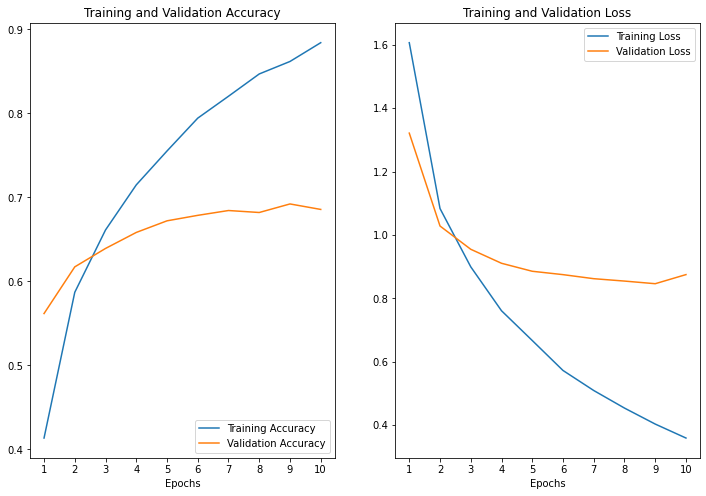

In [6]:
# VGG16 COLOR_RGB

In [7]:
model_loaded = keras.models.load_model(
        "output\keras_models\skin_classifier_VGG16_10_D521-D4-D512-D4_COLOR_RGB.keras")

Top 1 accuracy : 0.6856
Top 2 accuracy : 0.8666
Top 3 accuracy : 0.9413
Top 4 accuracy : 0.9747
Top 5 accuracy : 0.9924
Found 1005 images belonging to 7 classes.
Accuracy Score :  0.6677


,precision,recall,specificity,f1-score,support
label,,,,,
akiec,0.0000,0.0,1.0000,0.0000,33
bcc,0.0000,0.0,0.9985,0.0000,52
bkl,0.0000,0.0,0.9985,0.0000,110
df,0.0000,0.0,1.0000,0.0000,12
mel,0.0000,0.0,1.0000,0.0000,112
nv,0.6697,1.0,0.0000,0.8022,671
vasc,0.0000,0.0,0.9985,0.0000,15


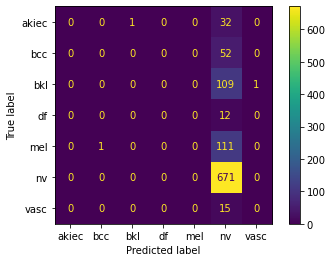

In [8]:
print_top_k_accuracy(model_loaded, test_data)
cm = print_confusion_matrix(model_loaded, IMAGES_PATH_VALIDATION)
cm

In [9]:
cm.mean()[0:4]

precision      0.095671
recall         0.142857
specificity    0.856500
f1-score       0.114600
dtype: float64

## Color HSV

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 512)        2048      
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                      

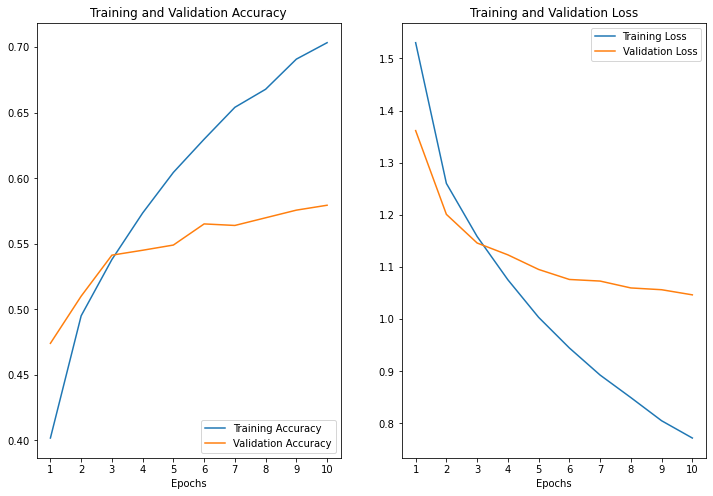

In [12]:
# VGG16 COLOR_HSV

In [13]:
model_loaded = keras.models.load_model(
        "output\keras_models\skin_classifier_VGG16_10_D521-D4-D512-D4_COLOR_HSV.keras")

Top 1 accuracy : 0.5794
Top 2 accuracy : 0.7924
Top 3 accuracy : 0.9082
Top 4 accuracy : 0.961
Top 5 accuracy : 0.9874
Found 1005 images belonging to 7 classes.
Accuracy Score :  0.6667


,precision,recall,specificity,f1-score,support
label,,,,,
akiec,0.0000,0.0000,1.0000,0.0,33
bcc,0.0000,0.0000,0.9985,0.0,52
bkl,0.0000,0.0000,1.0000,0.0,110
df,0.0000,0.0000,1.0000,0.0,12
mel,0.0000,0.0000,1.0000,0.0,112
nv,0.6673,0.9985,0.0000,0.8,671
vasc,0.0000,0.0000,1.0000,0.0,15


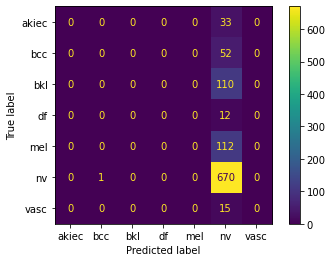

In [14]:
print_top_k_accuracy(model_loaded, test_data)
cm = print_confusion_matrix(model_loaded, IMAGES_PATH_VALIDATION)
cm

In [15]:
cm.mean()[0:4]

precision      0.095329
recall         0.142643
specificity    0.856929
f1-score       0.114286
dtype: float64

## ORIGINAL

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization_2 (Batc  (None, 7, 7, 512)        2048      
 hNormalization)                                                 
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                      

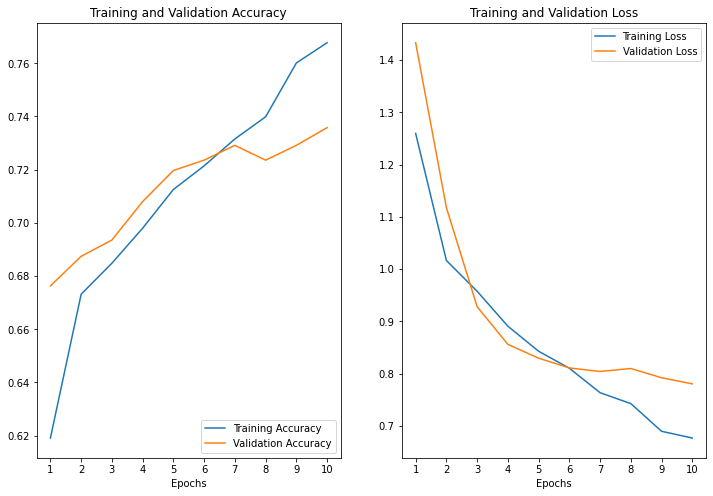

In [18]:
# ORIGINAL

In [19]:
model_loaded = keras.models.load_model(
        "output\keras_models\skin_classifier_VGG16_10_D521-D4-D512-D4_ORIGINAL_RERUN.keras")

Top 1 accuracy : 0.7358
Top 2 accuracy : 0.8721
Top 3 accuracy : 0.9472
Top 4 accuracy : 0.9772
Top 5 accuracy : 0.9922
Found 1005 images belonging to 7 classes.
Accuracy Score :  0.7353


precision      0.578829
recall         0.300129
specificity    0.881943
f1-score       0.350586
dtype: float64

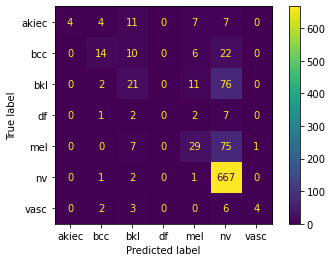

In [20]:
print_top_k_accuracy(model_loaded, test_data)
print_confusion_matrix(model_loaded, IMAGES_PATH_VALIDATION).mean()[0:4]

### CROP FLIP 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 512)        2048      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

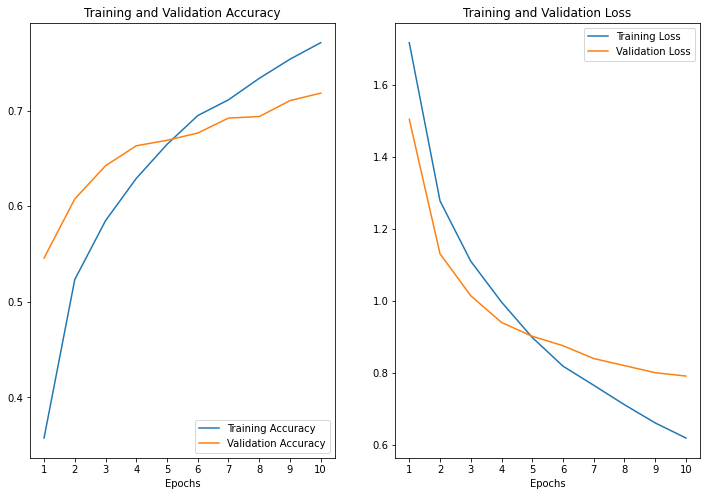

In [7]:
# VGG16 BN + Dense512+DO.4 + Dense512+DO.4 CROP+FLIP DATA

In [14]:
model_loaded = keras.models.load_model(
        "output\keras_models\skin_classifier_VGG16_10_D521-D4-D512-D4_CROP_FLIP.keras")

Top 1 accuracy : 0.3407
Top 2 accuracy : 0.6133
Top 3 accuracy : 0.7496
Top 4 accuracy : 0.8548
Top 5 accuracy : 0.9253
Found 1005 images belonging to 7 classes.
Accuracy Score :  0.6279


,precision,recall,specificity,f1-score,support
label,,,,,
akiec,0.8235,0.4242,0.9952,0.5600,33
bcc,0.4815,0.2500,0.9778,0.3291,52
bkl,0.2273,0.0455,0.9736,0.0758,110
df,0.0128,0.0833,0.8911,0.0222,12
mel,0.4444,0.0714,0.9842,0.1231,112
nv,0.7190,0.8733,0.1642,0.7887,671
vasc,0.1429,0.2667,0.9631,0.1860,15


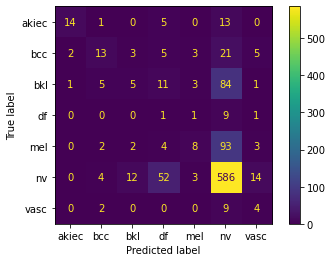

In [15]:
print_top_k_accuracy(model_loaded, test_data)
cm = print_confusion_matrix(model_loaded, IMAGES_PATH_VALIDATION)
cm

In [16]:
cm.mean()[0:4]

precision      0.407343
recall         0.287771
specificity    0.849886
f1-score       0.297843
dtype: float64

### ZOOM

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 512)        2048      
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                      

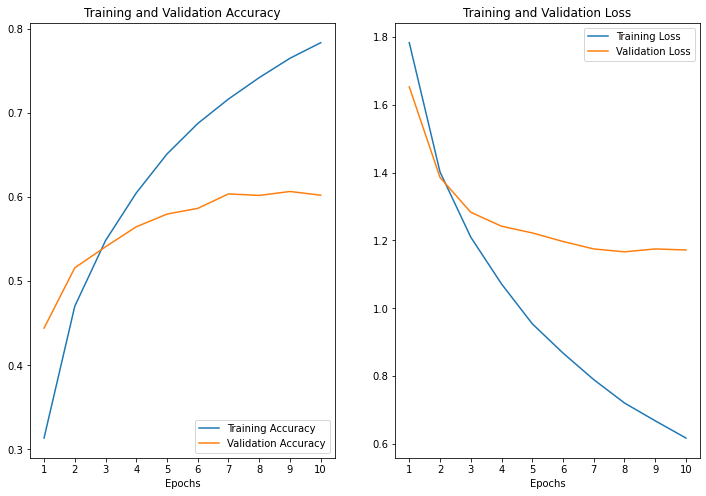

In [10]:
# VGG16 BN + Dense512+DO.4 + Dense512+DO.4 ZOOM DATA

In [17]:
model_loaded = keras.models.load_model(
        "output\keras_models\skin_classifier_VGG16_10_D521-D4-D512-D4_ZOOM.keras")

Top 1 accuracy : 0.6023
Top 2 accuracy : 0.7916
Top 3 accuracy : 0.8869
Top 4 accuracy : 0.9488
Top 5 accuracy : 0.9802
Found 1005 images belonging to 7 classes.
Accuracy Score :  0.7244


,precision,recall,specificity,f1-score,support
label,,,,,
akiec,0.4468,0.6364,0.9645,0.5250,33
bcc,0.5510,0.5192,0.9696,0.5347,52
bkl,0.3404,0.1455,0.9583,0.2038,110
df,0.1176,0.1667,0.9798,0.1379,12
mel,0.6562,0.1875,0.9847,0.2917,112
nv,0.8013,0.9434,0.3770,0.8665,671
vasc,0.3478,0.5333,0.9796,0.4211,15


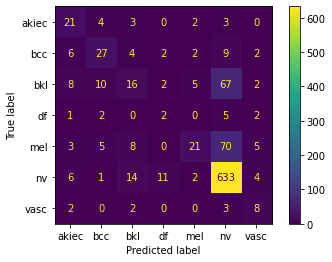

In [18]:
print_top_k_accuracy(model_loaded, test_data)
cm = print_confusion_matrix(model_loaded, IMAGES_PATH_VALIDATION)
cm

In [19]:
cm.mean()[0:4]

precision      0.465871
recall         0.447429
specificity    0.887643
f1-score       0.425814
dtype: float64

## Rotated

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization_2 (Batc  (None, 7, 7, 512)        2048      
 hNormalization)                                                 
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                      

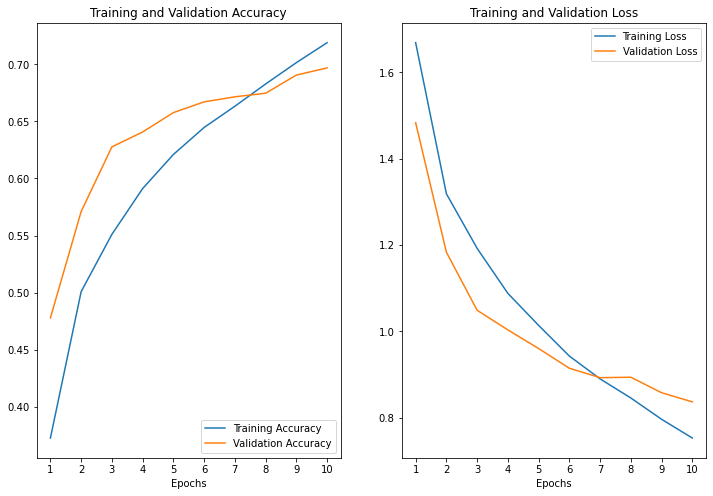

In [12]:
# VGG16 BN + Dense512+DO.4 + Dense512+DO.4 ROTATED DATA

In [19]:
model_loaded = keras.models.load_model(
        "output\keras_models\skin_classifier_VGG16_10_D521-D4-D512-D4_ROTATED.keras")

Top 1 accuracy : 0.6969
Top 2 accuracy : 0.8684
Top 3 accuracy : 0.9389
Top 4 accuracy : 0.9736
Top 5 accuracy : 0.9911
Found 1005 images belonging to 7 classes.
Accuracy Score :  0.7343


,precision,recall,specificity,f1-score,support
label,,,,,
akiec,0.7143,0.1515,0.9973,0.2500,33
bcc,0.4500,0.5192,0.9556,0.4821,52
bkl,0.3827,0.2818,0.9339,0.3246,110
df,0.0000,0.0000,0.9827,0.0000,12
mel,0.6341,0.2321,0.9794,0.3399,112
nv,0.8083,0.9553,0.3896,0.8757,671
vasc,0.8000,0.5333,0.9973,0.6400,15


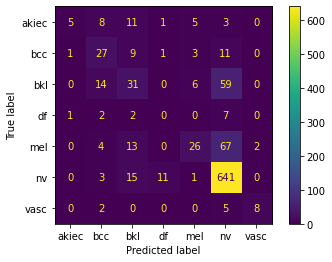

In [20]:
print_top_k_accuracy(model_loaded, test_data)
cm = print_confusion_matrix(model_loaded, IMAGES_PATH_VALIDATION)
cm

In [21]:
cm.mean()[0:4]

precision      0.541343
recall         0.381886
specificity    0.890829
f1-score       0.416043
dtype: float64

## EfficientNetB0 

In [58]:
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False # Not trainable weights
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_20 (Rescaling)       (None, 224, 224, 3)  0           ['input_14[0][0]']               
                                                                                                  
 normalization_4 (Normalization  (None, 224, 224, 3)  7          ['rescaling_20[0][0]']           
 )                                                                                                
                                                                                     

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_17 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_22 (Dropout)        (None, 1280)              0         
                                                                 
 dense_36 (Dense)            (None, 7)                 8967      
                                                                 
Total params: 4,058,538
Trainable params: 8,967
Non-trainable params: 4,049,571
_______________________________________

D:\Programs\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


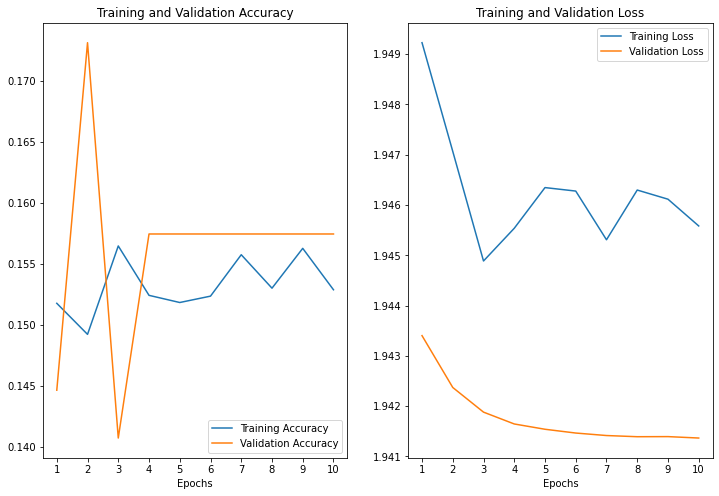

In [55]:
# EfficientNetB0 GAP + DO.4 

## VGG19

In [30]:
# Loading VGG16 model
base_model = VGG19(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False # Not trainable weights
base_model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 batch_normalization_5 (Batc  (None, 7, 7, 512)        2048      
 hNormalization)                                                 
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_18 (Dense)            (None, 512)               12845568  
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                      

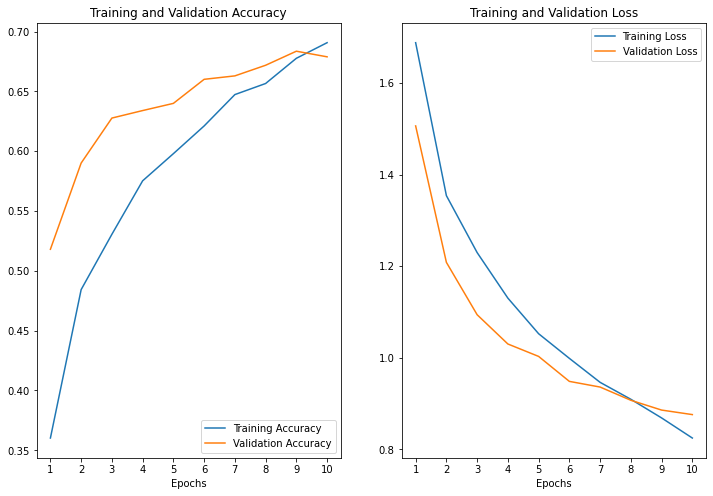

In [32]:
# Measure time
start_time = time.time()

epochs = 10
#weight_init = tf.keras.initializers.HeNormal()
#regularization = 0.005

model = Sequential([
    layers.Rescaling(1./255, input_shape=(224,224,3)),
    base_model,
    
    layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(512),
    layers.Dropout(0.4),
    layers.ReLU(),
    
    layers.Dense(512),
    layers.Dropout(0.4),
    layers.ReLU(),
    
    layers.Dense(7, activation="softmax")
])

model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001) 
# RMSprop(learning_rate=0.00002) # Adagrad() # Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)

#es = EarlyStopping(monitor='val_loss', mode='min', patience=3,  
#                   restore_best_weights=True, min_delta=0.01)

history = model.fit(train_data, validation_data=test_data, 
                    batch_size=batch_size, epochs=epochs) #, callbacks=[es])
epochs = len(history.history['loss'])

print("Epoch Length        : {0}".format(epochs))
print("Time Elapsed : ", timedelta(seconds=(time.time() - start_time)))

model.save("output\keras_models\skin_classifier_VGG16_{0}.keras".format(epochs))

print_training_history(history)

# VGG16 BN + Dense512+DO.4 + Dense512+DO.4 Balanced+Rotated  5 CLASSES##

## VGG16  TEST BINARY  (NO AKI)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization_8 (Batc  (None, 7, 7, 512)        2048      
 hNormalization)                                                 
                                                                 
 flatten_8 (Flatten)         (None, 25088)             0         
                                                                 
 dense_27 (Dense)            (None, 512)               12845568  
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                     

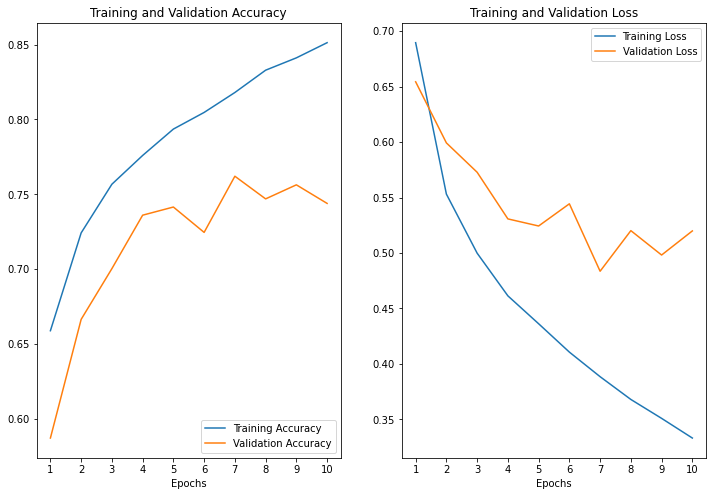

In [39]:
# VGG16 BN + Dense512+DO.4 + Dense512+DO.4 Balanced+Rotated  5 CLASSES##

## TEST _5 Classes

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 512)        2048      
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                      

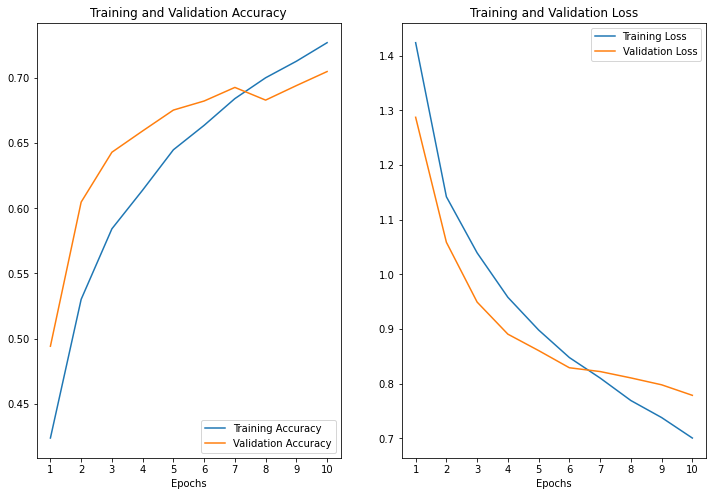

In [7]:
# VGG16 BN + Dense512+DO.4 + Dense512+DO.4 Balanced+Rotated  5 CLASSES##

## TEST _5 CLASSES 2

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization_3 (Batc  (None, 7, 7, 512)        2048      
 hNormalization)                                                 
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_9 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                      

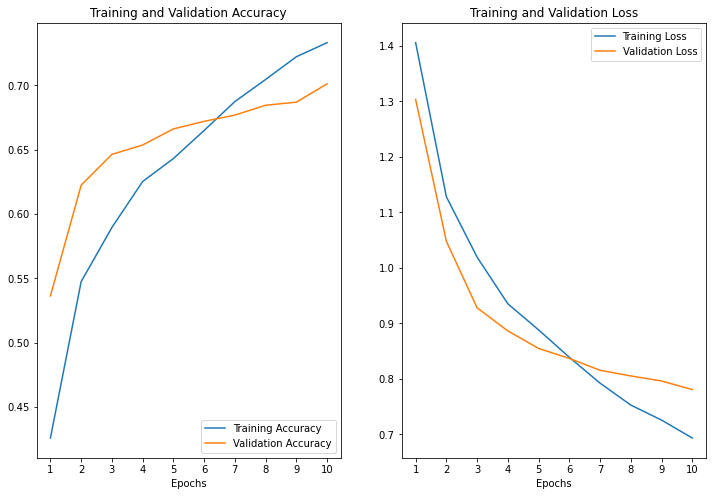

In [16]:
# VGG16 BN + Dense512+DO.4 + Dense512+DO.4 Balanced+Rotated  5 CLASSES##

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization_2 (Batc  (None, 7, 7, 512)        2048      
 hNormalization)                                                 
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                      

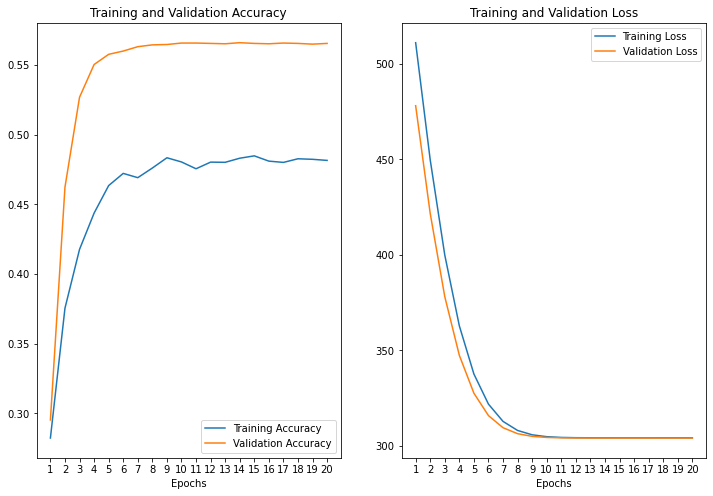

In [12]:
# VGG16 BN + Dense512+DO.5 + Dense512+DO.5 Balanced+Rotated LRS + L1 0.005 ##

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization_5 (Batc  (None, 7, 7, 512)        2048      
 hNormalization)                                                 
                                                                 
 flatten_6 (Flatten)         (None, 25088)             0         
                                                                 
 dense_18 (Dense)            (None, 512)               12845568  
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                      

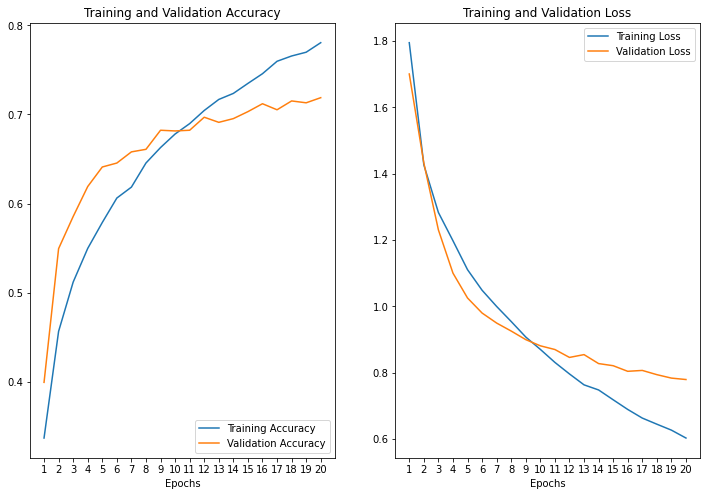

In [22]:
# VGG16 BN + Dense512+DO.4 + Dense512+DO.4 Balanced+Rotated ##

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization_6 (Batc  (None, 7, 7, 512)        2048      
 hNormalization)                                                 
                                                                 
 flatten_7 (Flatten)         (None, 25088)             0         
                                                                 
 dense_21 (Dense)            (None, 512)               12845568  
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                      

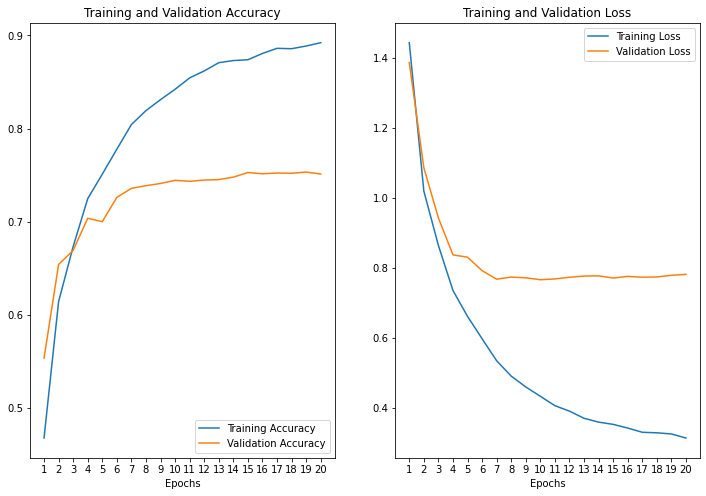

In [24]:
# VGG16 BN + Dense512+DO.4 + Dense512+DO.4 Balanced+Rotated LRS ##

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization_7 (Batc  (None, 7, 7, 512)        2048      
 hNormalization)                                                 
                                                                 
 flatten_8 (Flatten)         (None, 25088)             0         
                                                                 
 dense_24 (Dense)            (None, 512)               12845568  
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                      

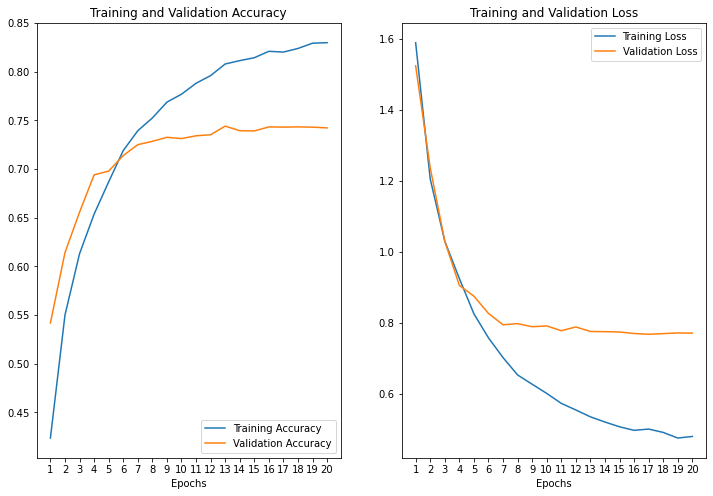

In [25]:
# VGG16 BN + Dense512+DO.5 + Dense512+DO.5 Balanced+Rotated LRS ##

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization_3 (Batc  (None, 7, 7, 512)        2048      
 hNormalization)                                                 
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_12 (Dense)            (None, 512)               12845568  
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                      

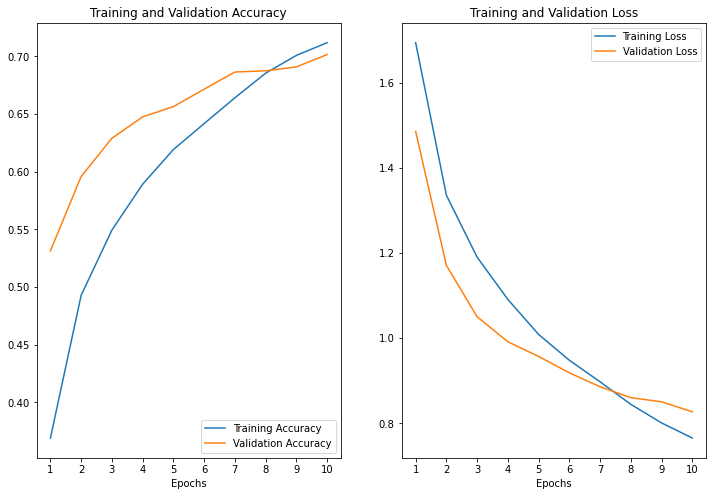

In [18]:
# VGG16 BN + Dense512+DO.4 + Dense512+DO.4 Balanced+Rotated ##

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 512)        2048      
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               12845568  
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                      

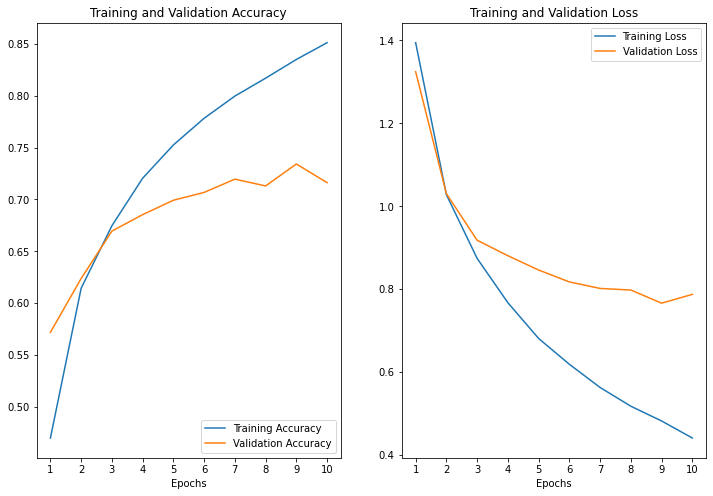

In [12]:
# VGG16 BN + Dense512+Dense512 + DO.3 Balanced+Rotated kullback_leibler_divergence ##

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 512)        2048      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                        

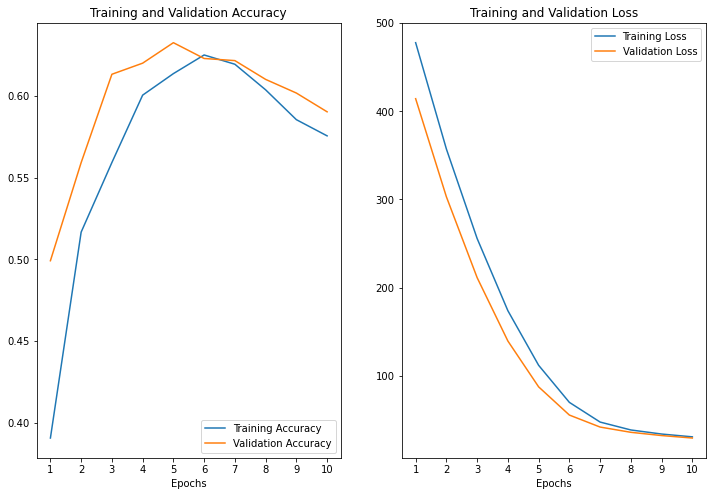

In [10]:
# VGG16 BN + Dense512+Dense512 + DO.3 + L1 0.005 Balanced+Rotated ##

## ResNet50

In [19]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False # Not trainable weights
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 7)                 14343     
                                                                 
Total params: 23,602,055
Trainable params: 14,343
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/30
240/240 [==============================] - 722s 3s/step - loss: 1.9938 - accuracy: 0.1534 - 

D:\Programs\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


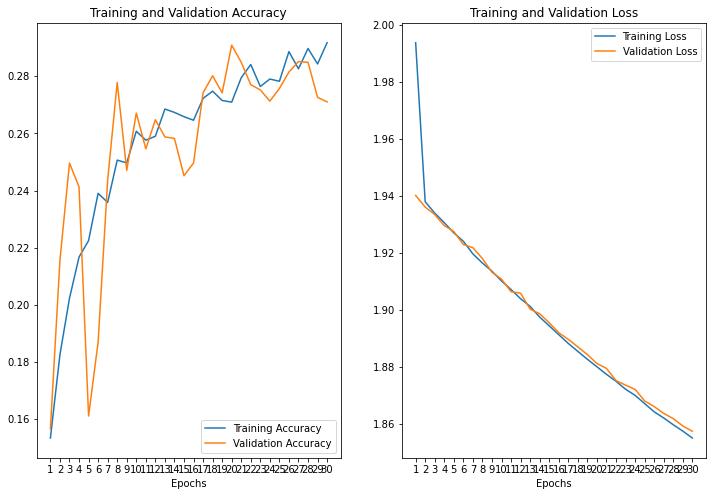

In [23]:

# First run on the model the was no overfitting
# but overal model was weak, so decided to try differnt optimizer
# Small rate used for transfer learning

# Optimization algorithms in machine learning (especially in neural networks) 
# aim at minimizing an objective function (generally called loss or cost function), 
# which is intuitively the difference between the predicted data and the expected values

# Although ADAGRAD works well for sparse settings, 
# its performance has been observed to deteriorate in settings 
# where the loss functions are nonconvex and gradients are dense 
# due to the rapid decay of the learning rate in these settings 
# since it uses all the past gradients in the update

# Simply put, RMSprop uses an adaptive learning rate 
# instead of treating the learning rate as a hyperparameter. 
# This means that the learning rate changes over time

# ResNet50 + GAP, Balanced+Rotated

Epoch 1/10
240/240 [==============================] - 664s 3s/step - loss: 2.1541 - accuracy: 0.1567 - val_loss: 2.0633 - val_accuracy: 0.1567
Epoch 2/10
240/240 [==============================] - 662s 3s/step - loss: 2.0149 - accuracy: 0.1567 - val_loss: 1.9791 - val_accuracy: 0.1567
Epoch 3/10
240/240 [==============================] - 663s 3s/step - loss: 1.9633 - accuracy: 0.1569 - val_loss: 1.9513 - val_accuracy: 0.1577
Epoch 4/10
240/240 [==============================] - 662s 3s/step - loss: 1.9473 - accuracy: 0.1567 - val_loss: 1.9435 - val_accuracy: 0.1548
Epoch 5/10
240/240 [==============================] - 662s 3s/step - loss: 1.9433 - accuracy: 0.1559 - val_loss: 1.9418 - val_accuracy: 0.1504
Epoch 6/10
240/240 [==============================] - 662s 3s/step - loss: 1.9423 - accuracy: 0.1554 - val_loss: 1.9412 - val_accuracy: 0.1462
Epoch 7/10
240/240 [==============================] - 662s 3s/step - loss: 1.9419 - accuracy: 0.1371 - val_loss: 1.9408 - val_accuracy: 0.1311

D:\Programs\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


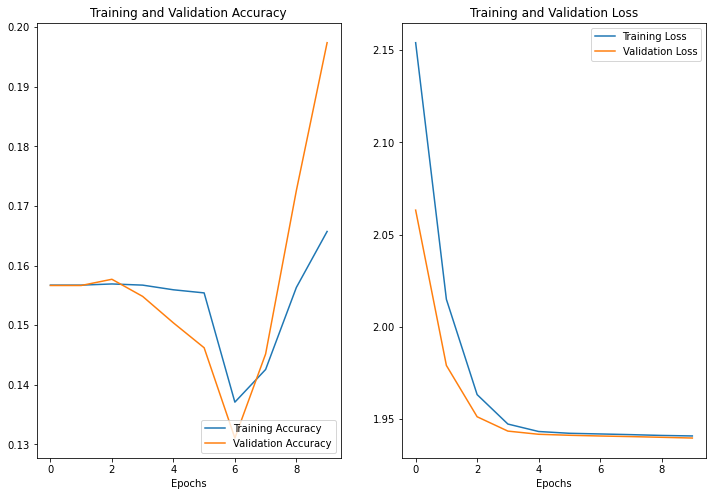

In [9]:
# ResNet50 + GAP, Balanced+Rotated